In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Bird Sound Classifier 

### Credits

This system is based on the [2018 BirdCLEF-Baseline System](https://github.com/kahst/BirdCLEF-Baseline)
and has been re-implemented and ported over to fastai2's audio library. 

Table of Contents

1- Introduction

2- The Dataset

3- Sorting/Extracting the Data

4- Generating Spectrograms

5- Training

6- Evaluation

## Introduction

## Downloading and Extracting the Dataset

#### From CrowdAI, where I got the dataset:

> The training set composed of xml and wav files is composed of 36496 recordings of 1500 bird species collected in the following coutries: Brazil, Colombia, Venezuela, Guyana, Suriname, French Guiana, Peru, Ecuador and Bolivia. It is composed of two parts to be downloaded separately:
> - the first part contains 24,607 audio recordings belonging to 999 bird species (LifeCLEF 2016 training set):
> http://otmedia.lirmm.fr/LifeCLEF/BirdCLEF2017/BirdCLEF2017TrainingSetPart1.tar.gz
> - the second part contains 11,889 audio recordings belonging to 501 specis (introduced in LifeCLEF 2017 training set):
> http://otmedia.lirmm.fr/LifeCLEF/BirdCLEF2017/BirdCLEF2017TrainingSetPart2.tar.gz


Please be warned: The first part is xx gb, and the second part is xx gb. Fully extracted the dataset is xxx gb!

You can download each dataset as follows:

`curl -O http://otmedia.lirmm.fr/LifeCLEF/BirdCLEF2017/BirdCLEF2017TrainingSetPart1.tar.gz`

`curl -O http://otmedia.lirmm.fr/LifeCLEF/BirdCLEF2017/BirdCLEF2017TrainingSetPart2.tar.gz`

and untar'ing like so:

`tar BirdCLEF2017TrainingSetPart1.tar.gz`

`tar BirdCLEF2017TrainingSetPart2.tar.gz`

BirdCLEF2017TrainingSetPart2.tar.gz seems to have put all the data into one flat folder, mixing the wav and xml files, so I moved them into the TraningSet folder created by `tar BirdCLEF2017TrainingSetPart1.tar.gz` with the following lines:

`mv data/*.wav TrainingSet/wav/`

`mv data/*.xml TrainingSet/xml/`

Now you can remove that empty `data` folder:

`rm -r data`

## Sorting the Dataset

fastai will take care of splitting out dataset into a training and validation set, so we can skip that for now and just put all of our data into class directories.

### TODO: Insert cells with sample of XML

In [ ]:
# Imports for this section

import os
from pathlib import Path
import xmltodict as x2d
from tqdm.notebook import tqdm, trange
import json
from shutil import copyfile

In [ ]:
# Some constants used in this part of the notebook
TRAININGSET_PATH = '../../TrainingSet/'

In [ ]:
def parseDataset():
    metadata = {}
    
    # list of wav files
    wav_path = Path(TRAININGSET_PATH)/'wav'
    #wav_files = [f for f in sorted(wav_path.iterdir()) if f.is_file()] make iterdir return just file names, not full paths
    wav_files = [f for f in sorted(os.listdir(wav_path))]
    print("dataset containts {} wav files".format(len(wav_files)))
    
    # list all xml files
    xml_path = Path(TRAININGSET_PATH)/'xml'
    #xml_files = [f for f in sorted(xml_path.iterdir()) if f.is_file()] make iterdir return just filenames, not full paths
    xml_files = [os.path.join(xml_path, f) for f in sorted(os.listdir(xml_path))]
    print("parsing {} xml files".format(len(xml_files)))
    
    for i in trange(len(xml_files)):
        
        # read content
        xml = open(xml_files[i], 'r').read()
        data = x2d.parse(xml)
        
        # the 2017 dataset has no annotated background species
        # we have to handle those separately
        try:
            background = data['Audio']['BackgroundSpecies'].split(',')
        except:
            background = []
            
        # create new metadata
        mdata = {
                    'sci-name' : data['Audio']['Genus'] + ' ' + data['Audio']['Species'],
                    'species' : data['Audio']['VernacularNames'].split(',')[0],
                    'background' : background,
                    'filename' : data['Audio']['FileName'],
                    'classid' : data['Audio']['ClassId']
                }
        
       # save metadata to dict if wav file exists
        if mdata['filename'] in wav_files:
            if not mdata['classid'] in metadata:
                metadata[mdata['classid']] = []
            metadata[mdata['classid']].append(mdata)
            
            
        #if not i % 100:
        #   print('\t', i, '/', len(xml_files))
            
    print("done! there are {} classes in the dataset".format(len(metadata)))

    return metadata
    


In [ ]:
def parseDataset():
    metadata = {}
    
    # list of wav files
    wav_path = Path(TRAININGSET_PATH)/'wav'
    #wav_files = [f for f in sorted(wav_path.iterdir()) if f.is_file()] make iterdir return just file names, not full paths
    wav_files = [f for f in sorted(os.listdir(wav_path))]
    print("dataset containts {} wav files".format(len(wav_files)))
    
    # list all xml files
    xml_path = Path(TRAININGSET_PATH)/'xml'
    #xml_files = [f for f in sorted(xml_path.iterdir()) if f.is_file()] make iterdir return just filenames, not full paths
    xml_files = [os.path.join(xml_path, f) for f in sorted(os.listdir(xml_path))]
    print("parsing {} xml files".format(len(xml_files)))
    
    for i in trange(len(xml_files)):
        
        # read content
        xml = open(xml_files[i], 'r').read()
        data = x2d.parse(xml)
        
        # the 2017 dataset has no annotated background species
        # we have to handle those separately
        try:
            background = data['Audio']['BackgroundSpecies'].split(',')
        except:
            background = []
            
        # create new metadata
        mdata = {
                    'sci-name' : data['Audio']['Genus'] + ' ' + data['Audio']['Species'],
                    'species' : data['Audio']['VernacularNames'].split(',')[0],
                    'background' : background,
                    'filename' : data['Audio']['FileName'],
                    'classid' : data['Audio']['ClassId']
                }
        
       # save metadata to dict if wav file exists
        if mdata['filename'] in wav_files:
            if not mdata['classid'] in metadata:
                metadata[mdata['classid']] = []
            metadata[mdata['classid']].append(mdata)
            
            
        #if not i % 100:
        #   print('\t', i, '/', len(xml_files))
            
    print("done! there are {} classes in the dataset".format(len(metadata)))

    return metadata
    


In [ ]:
def sortDataset(mdata):
    print("parsing classes")
    for c in mdata:
        #print('\t', c)
        for f in mdata[c]:
            
        # we're going to skip creating our validation set and let fastai handle that for us
        
        # get the class name (use the sci name to make it easier to evaluate with background species)
        # the submission format usees class id only - so we have to figure that out later
        
            cname = f['sci-name']
            
            m_path = Path(TRAININGSET_PATH)/'metadata'
            if not os.path.exists(m_path):
                os.makedirs(m_path)

            t_path = Path(TRAININGSET_PATH)/'train'/cname    
            if not os.path.exists(t_path):
                os.makedirs(t_path)

            # copy files!
            with open(os.path.join(m_path, f['filename'].rsplit('.')[0] + '.json'), 'w') as mfile:
                json.dump(f, mfile)

            copyfile(os.path.join(Path(TRAININGSET_PATH)/'wav', f['filename']), os.path.join(t_path, f['filename']))
        
    print("done!")

In [ ]:
#metadata = parseDataset()
#print(len(metadata))
#sortDataset(metadata)

## Generating Spectrograms from the Dataset

Borrowed from:

https://github.com/kahst/BirdCLEF-Baseline/blob/master/utils/audio.py

https://github.com/kahst/BirdCLEF-Baseline/blob/master/spec.py

In [ ]:
# imports for this section of the notebook

import os
from pathlib import Path
import cv2
import matplotlib.pyplot as plt
import numpy as np
import librosa
from tqdm.notebook import tqdm, trange

In [ ]:
# config values for this section of the notebook

TRAININGSET_PATH = '../../TrainingSet/'
SAMPLE_RATE = 44100
SPEC_LENGTH = 1.0
SPEC_OVERLAP = 0.25
SPEC_MINLEN = 1.0
SPEC_FMIN = 500
SPEC_FMAX = 15000
SPEC_TYPE = 'melspec'
SPEC_SIGNAL_THRESHOLD = 0.001
IMG_SIZE = (256, 128)
MAX_SPECS_PER_CLASS = 1000
RANDOM = np.random.RandomState(2020)

In [ ]:
def openAudioFile(path, sample_rate=44100, as_mono=True, mean_subtract=False):
    
    # open the file with librosa (uses ffmpeg or libav)
    sig, rate = librosa.load(path, sr=sample_rate, mono=as_mono)
    
    # noise reduction
    if mean_subtract:
        sig -= sig.mean()
        
    return sig, rate

In [ ]:
def splitSignal(sig, rate, seconds, overlap, minlen):
    
    # split signal with overlap
    sig_splits = []
    for i in range(0, len(sig), int((seconds - overlap) * rate)):
        split = sig[i:i + int(seconds * rate)]
        
        # end of signal?
        if len(split) < int(minlen * rate):
            break
            
        if len(split) < int(rate * seconds):
            split = np.hstack((split, np.zeros((int(rate * seconds) - len(split),))))
        
        sig_splits.append(split)
    return sig_splits 

In [ ]:
def melspec(sig, rate, shape=(128,256), fmin=500, fmax=15000, normalize=True, preemphasis=0.95):
    
    #mel spec parameters
    SAMPLE_RATE = rate
    N_FFT = shape[0] * 8 # window length
    N_MELS = shape[0]
    HOP_LEN = len(sig) // (shape[1] - 1)
    FMAX = fmax
    FMIN = fmin
    
    # pre emphasis seems to be a thing used in python_speech_features by James Lyon
    # https://github.com/jameslyons/python_speech_features
    # http://www.practicalcryptography.com/miscellaneous/machine-learning/guide-mel-frequency-cepstral-coefficients-mfccs/
    
    if preemphasis:
        sig = np.append(sig[0], sig[1:] - preemphasis * sig[:-1])
        
    # generate melspec from librosa
    melspec = librosa.feature.melspectrogram(y=sig, sr=SAMPLE_RATE, hop_length=HOP_LEN, n_fft=N_FFT, n_mels=N_MELS, fmax=FMAX, fmin=FMIN, power=1.0)
    
    # convert power spec to db scale (log mel spec)
    melspec = librosa.amplitude_to_db(melspec, ref=np.max, top_db=80)
    
    # flip spectrum vertically (only for better visualization, low freq at bottom)
    melspec = melspec[::-1, ...]
    
    # trim to desired shape if too large
    melspec = melspec[:shape[0], :shape[1]]
    
    # normalize values between 0 and 1
    if normalize:
        melspec -= melspec.min()
        if not melspec.max() == 0:
            melspec /= melspec.max()
        else:
            melspec = np.clip(melspec, 0, 1)
    return melspec.astype('float32')
    

In [ ]:
def stft(sig, rate, shape=(128, 256), fmin=500, fmax=15000, normalize=True):
       
        #stft-spec parameters
        N_FTT = int((rate * shape[0] * 2) / abs(fmin - fmax)) + 1
        P_MIN = int(float(N_FFT / 2) / rate * fmin) + 1
        P_MAX = int(float(N_FFT / 2) / rate * fmax) + 1
        HOP_LEN = len(sig) // (shape[1] - 1)
        
        # generate stft-spectrum with librosa
        spec = librosa.core.stft(sig, hop_length=HOP_LEN, n_fft=N_FTT, window='hamm')
        
        # convert spec to db scale (log spec)
        spec = librosa.amplitude_to_db(librosa.core.magphase(spec)[0], ref=np.max, top_db=80)
        
        # trip to desired shape using cutoff frequencies
        spec = spec[P_MIN:P_MAX, :shape[1]]
        
        # flip spectrum vertically (only for better visualization, low freq at bottom)
        spec = spec[::-1, ...]
        
        # normalize values between 0 and 1
        
        if normalize:
            spec -= spec.min()
            if not spec.max() == 0:
                spec /= spec.max()
            else:
                spec = np.clip(spec, 0, 1)
                
        return spec.astype('float32')
    
    

In [ ]:
def get_spec(sig, rate, shape, spec_type='linear', **kwargs):
    if spec_type.lower() == 'melspec':
        return melspec(sig, rate, shape, **kwargs)
    else:
        return stft(sig, rate, shape, **kwargs)

In [ ]:
def signal2noise(spec):
    
    #get a working copy
    spec = spec.copy()
    
    # calculate median for columns and rows
    col_median = np.median(spec, axis=0, keepdims=True)
    row_median = np.median(spec, axis=1, keepdims=True)
    
    # binary threshold
    spec[spec < row_median * 1.25] = 0.0
    spec[spec < col_median * 1.15] = 0.0
    spec[spec > 0] = 1.0
    
    # median blur
    spec = cv2.medianBlur(spec, 3)
    
    # morphology
    spec = cv2.morphologyEx(spec, cv2.MORPH_CLOSE, np.ones((3, 3), np.float32))
    
    # sum all the values
    spec_sum = spec.sum()
    
    try:
        s2n = spec_sum / (spec.shape[0] * spec.shape[1] * spec.shape[2])
    except:
        s2n = spec_sum / (spec.shape[0] * spec.shape[1])
    
    return s2n

In [ ]:
def specsFromSignal(sig, rate, shape, seconds, overlap, minlen, **kwargs):
    
    # split signal in consecutive chunks with overlap
    sig_splits = splitSignal(sig, rate, seconds, overlap, minlen)
    
    # extract specs for every signal split
    for sig in sig_splits:
       
        # get spec for signal chunk
        spec = get_spec(sig, rate, shape, **kwargs)
        
        yield spec

In [ ]:
def specsFromFile(path, rate, seconds, overlap, minlen, shape, start=-1, end=-1, **kwargs):
    
    # open file
    sig, rate = openAudioFile(path, rate)
    #print(sig, rate)
    
    # trim signal
    if start > -1 and end > -1:
        sig = sig[int(start * rate):int(end*rate)]
        minlen = 0
        
    # produce all specs for file
    for spec in specsFromSignal(sig, rate, shape, seconds, overlap, minlen, **kwargs):
        yield spec

0.008148193359375


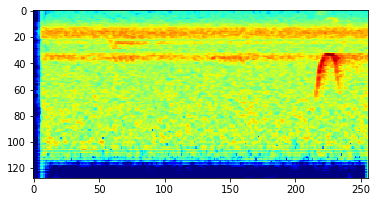

0.007080078125


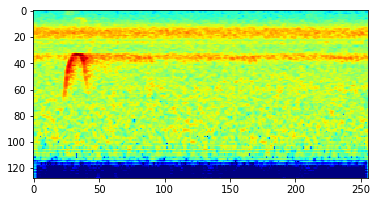

0.0


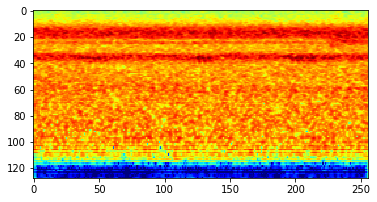

0.0


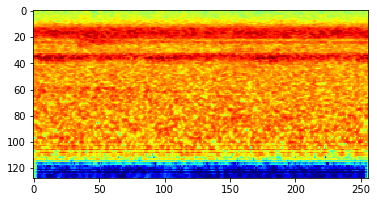

0.009124755859375


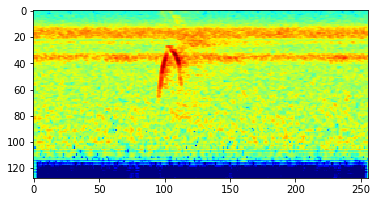

0.0


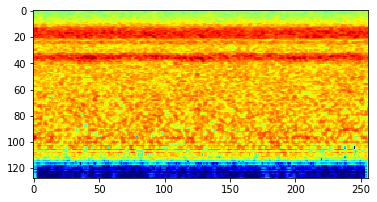

0.00372314453125


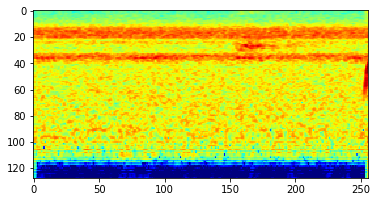

0.007965087890625


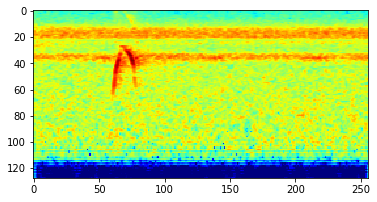

0.0


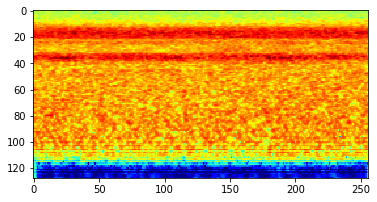

0.00592041015625


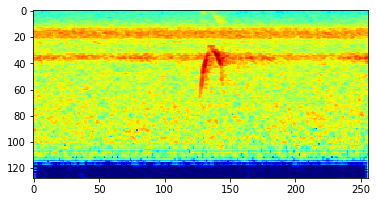

0.0


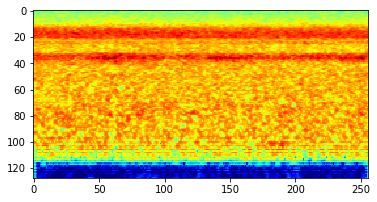

0.0


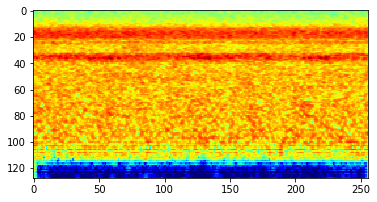

0.0


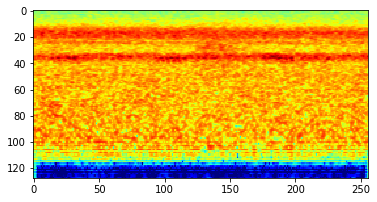

0.0


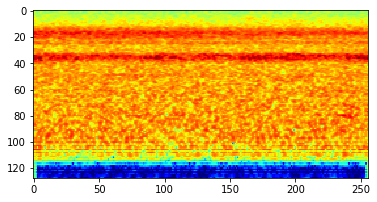

0.008453369140625


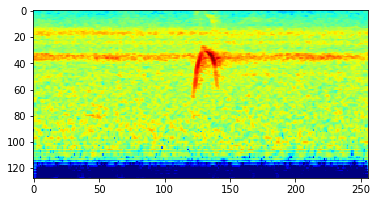

0.0


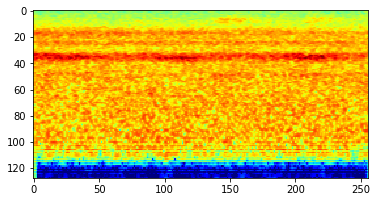

0.005859375


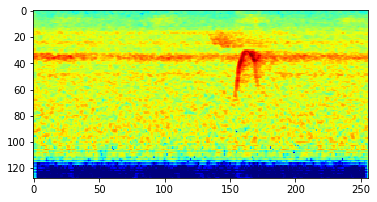

In [ ]:
# test making a spec from a file
# https://github.com/kahst/BirdCLEF-Baseline/tree/master/example
    
specs = specsFromFile(#'../../TrainingSet/train/Aburria aburri/LIFECLEF2015_BIRDAMAZON_XC_WAV_RN14987.wav',
                      'Acadian%20Flycatcher.wav',
                         rate = SAMPLE_RATE,
                         seconds = SPEC_LENGTH,
                         overlap = SPEC_OVERLAP,
                         minlen = SPEC_MINLEN,
                         shape = (IMG_SIZE[1], IMG_SIZE[0]),
                         fmin = SPEC_FMIN,
                         fmax = SPEC_FMAX,
                         spec_type = 'melspec'
                        )

for spec in specs:    
    noise = signal2noise(spec)
    print(noise)
    
    plt.imshow(spec, cmap='jet')
    plt.show()



In [ ]:
def getSpecs(path):
    
    specs = []
    noise = []
    # get mel-specs for file
    #print("getting specs for ", path) 
    for spec in specsFromFile(path, 
                                    rate = SAMPLE_RATE, 
                                    seconds = SPEC_LENGTH,
                                    overlap = SPEC_OVERLAP, 
                                    minlen = SPEC_MINLEN, 
                                    fmin = SPEC_FMIN, 
                                    fmax = SPEC_FMAX, 
                                    spec_type = SPEC_TYPE,
                                    shape = (IMG_SIZE[1], IMG_SIZE[0])
                               ):
        
        #print("spec:", spec)
        # determine signal to noise ratio
        s2n = signal2noise(spec)
        #print(s2n)
        specs.append(spec) 
        noise.append(s2n) 
        
    # shuffle arrays (we want to select randomly later)
    #specs, noise = shuffle(specs, noise, random_state=RANDON)
    #print("number of specs: ", len(specs), "number of lengths: ", len(noise))
    
    return specs, noise
                                   
            

In [ ]:
def generateSpecs():
    
    # list of classes, subfolders as class names
    classes = [c for c in sorted(os.listdir(Path(TRAININGSET_PATH)/'train'))]
    
    # parse every class
    for c in tqdm(classes):
        print(c) 
        # list of all audio files
        afiles = [f for f in sorted(os.listdir(Path(TRAININGSET_PATH)/'train'/c))]
        # calculate maximum specs per file
        max_specs = MAX_SPECS_PER_CLASS // len(afiles) + 1
        
        # get spec for every audio file
        for i in trange(len(afiles)):
            
            spec_cnt = 0
            
            try:
                specs, noise = getSpecs(Path(TRAININGSET_PATH)/'train'/c/afiles[i])
                #print(len(specs))
                for s in range(len(specs)):

                    # NaN?
                    if np.isnan(noise[s]):
                        noise[s] = 0.0

                    if noise[s] >= SPEC_SIGNAL_THRESHOLD:

                        #create target path for accepted specs
                        filepath = Path(TRAININGSET_PATH)/'spec'/c
                        
                        if not os.path.exists(filepath):
                            os.makedirs(filepath)
                        
                        spec_cnt += 1
                        
                    else:
                        
                        # create target path for rejected specs
                        # but only save 10% (used in training as noise?)
                        
                        if RANDOM.choice([True, False], p=[0.1, 0.90]): #
                            filepath = Path(TRAININGSET_PATH)/'noise'
                            if not os.path.exists(filepath):
                                os.makedirs(filepath)
                        else: filepath = None
                    
                    if filepath:
                        #filename contains s2n ratio
                        filename = str(int(noise[s] * 10000)).zfill(4) + '_' + afiles[i].split('.')[0] + '_' + str(s).zfill(3)
                        
                        # write file (why cv2?)
                        cv2.imwrite(os.path.join(filepath, filename + '.png'), specs[s] * 255.0)
                        
                        #if we have enoughs specs, end
                        
                    
                    if spec_cnt >= max_specs:
                        break
            except:
                print("error during spec extract!")
                continue
                
                        
                            
                            
            

In [ ]:
# parse dataset and genetate specs
generateSpecs()

Aburria aburri



Accipiter bicolor



Accipiter poliogaster



Accipiter superciliosus



Acropternis orthonyx



Actitis macularius



Adelomyia melanogenys


## Research

[Recognizing Birds from Sound -The 2018 BirdCLEF Baseline System](https://arxiv.org/pdf/1804.07177.pdf)

[Eventness: Object Detection on Spectrograms for Temporal Localization of Audio Events](https://arxiv.org/abs/1712.09668)

## Notes

- swap out cv for matplotlib?
- try to see if we can get the split beginning-end time and use that to generate onset off times so we can just make specs on signal

## Training on our Spectrograms

In [ ]:
from pathlib import Path

# Some constants used in this part of the notebook
SPECTROGRAM_PATH = '../../spec/'

In [ ]:
from fastai2.basics import *
from fastai2.callback.all import *
from fastai2.vision.all import *

In [ ]:
spectrograms = DataBlock(blocks=(ImageBlock, CategoryBlock),
                        get_items=get_image_files,
                         splitter=RandomSplitter(),
                         get_y=parent_label
                        )

In [ ]:
dbunch = spectrograms.databunch(Path(SPECTROGRAM_PATH),
                      items_tfms=RandomResizedCropGPU(460, min_scale=0.75),
                      bs=32
                      
                     )

In [ ]:
len(dbunch.train_ds.items)

700850

In [ ]:
len(dbunch.valid_ds.items)

175212

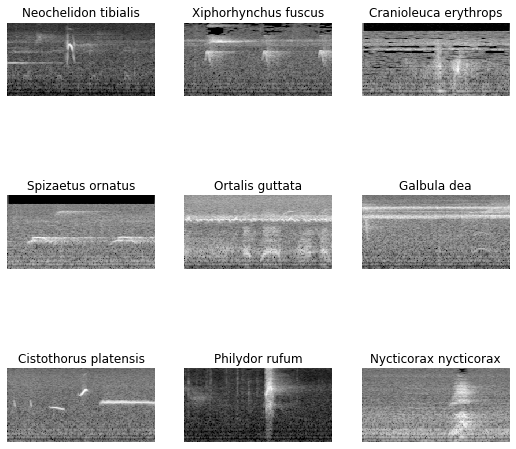

In [ ]:
dbunch.show_batch(max_n=9)

In [ ]:
from torchvision.models import resnet34, resnet50

In [ ]:
opt_func = partial(Adam, lr=slice(3e-3), wd=0.01, eps=1e-8)

In [ ]:
learn = cnn_learner(dbunch, resnet34, opt_func=opt_func, metrics=error_rate, config=cnn_config(ps=0.33)).to_fp16()

In [ ]:
torch.cuda.get_device_name(0)

'GeForce GTX 1080 Ti'

In [ ]:
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,error_rate,time
0,4.155685,3.466661,0.606174,29:57
1,4.364867,3.578975,0.635841,29:58
2,4.080368,3.286897,0.588053,30:02
3,3.889002,3.062053,0.552348,30:01
4,3.663337,2.868032,0.519491,30:01
5,3.538924,2.695339,0.489253,29:54
6,3.356479,2.539256,0.455699,30:08
7,3.237156,2.383141,0.417899,30:10
8,2.988107,2.299940,0.389140,30:13
9,2.881463,2.268415,0.380796,30:17


In [ ]:
learn.save('bird-classifier-10-one-fit-cycles')

In [ ]:
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,error_rate,time
0,3.446736,2.578537,0.467965,29:56
1,4.100397,3.013068,0.556052,30:01
2,3.643241,2.867611,0.525883,30:06
3,3.609569,2.723988,0.498870,30:12
4,3.518674,2.610258,0.479499,30:07
5,3.351932,2.467631,0.450123,30:09
6,3.132668,2.328574,0.419629,30:07
7,3.003092,2.205428,0.383946,30:00
8,2.874613,2.129609,0.357105,29:57
9,2.830171,2.103695,0.350547,30:09


In [ ]:
learn.fit_one_cycle(20)

epoch,train_loss,valid_loss,error_rate,time
0,5.915662,5.490457,0.870277,29:36
1,4.609889,4.018661,0.687048,29:37
2,4.385045,3.623804,0.640430,29:35
3,4.190367,3.446201,0.617635,29:34
4,4.026202,3.238094,0.584498,29:38
5,3.968424,3.059710,0.551851,29:40
6,3.786431,2.949801,0.538114,29:41
7,3.680182,2.852813,0.518583,29:34
8,3.613706,2.758873,0.503984,29:38
9,3.506496,2.672097,0.489681,29:47


In [ ]:
learn.save("bird-classifier-20-one-fit-cycles")

In [ ]:
learn.unfreeze()

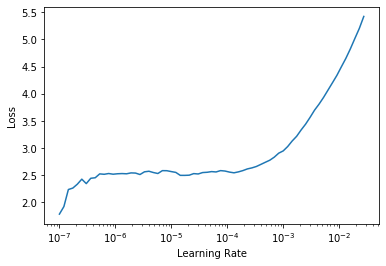

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(30, lr_max=slice(3e-7, 3e-6))

epoch,train_loss,valid_loss,error_rate,time
0,2.628088,2.143889,0.349765,40:23
1,2.700262,2.119308,0.348458,40:23
2,2.566366,2.075973,0.345205,40:18
3,2.596005,2.057625,0.340325,40:23
4,2.582493,2.014700,0.333402,40:15
5,2.500089,2.004181,0.331045,40:35
6,2.473974,1.975057,0.324321,40:23
7,2.421195,1.948461,0.319487,40:32
8,2.404032,1.924052,0.313951,40:26
9,2.421763,1.908593,0.311063,40:24


# notes


conda install pytorch=1.2.0 -c pytorch - https://forums.fast.ai/t/getting-started-with-fastai-v2/53927/43

PIL issues
pip install Pillow==6.2.1 - https://forums.fast.ai/t/fastai-v2-chat/53518/531